In [1]:
from typing import List, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from IPython.display import display
except Exception:
    display = print


# ========= General utilities =========

def _safe_log1p(x: pd.Series, eps: float = 1e-9) -> pd.Series:
    return np.log1p(np.clip(x, a_min=-0.999999999 + eps, a_max=None))

def _topn(s: pd.Series, n: int = 10) -> pd.Series:
    return s.sort_values(ascending=False).head(n)

def _plot_hist(series: pd.Series, title: str, bins: int = 30):
    plt.figure()
    plt.hist(series.dropna().values, bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Count")
    plt.show()

def _plot_bar(series: pd.Series, title: str, rotate=45):
    plt.figure()
    series.plot(kind="bar")
    plt.title(title)
    plt.xlabel(series.index.name if series.index.name else "")
    plt.ylabel("Value")
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()

def _plot_scatter(x: pd.Series, y: pd.Series, title: str, xlabel: str, ylabel: str, s: int = 8):
    plt.figure()
    plt.scatter(x.values, y.values, s=s)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def _plot_boxplot(vals_list: List[np.ndarray], labels: List[str], title: str, ylabel: str):
    plt.figure()
    plt.boxplot(vals_list, labels=labels, showfliers=False)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()


# ========= General EDA =========

def eda_overview(train: pd.DataFrame, test: pd.DataFrame, target_col: str = "Item_Outlet_Sales"):
    print("==== EDA Overview ====")
    print(f"Train shape: {train.shape}  |  Test shape: {test.shape}")
    print("\nTrain columns:")
    print(list(train.columns))
    print("\nTest columns:")
    print(list(test.columns))

    print("\nTrain head:")
    display(train.head(3))
    print("\nTest head:")
    display(test.head(3))

    # Missingness
    def _miss(df):
        m = df.isna().sum().sort_values(ascending=False)
        return pd.DataFrame({"missing": m, "missing_%": (m / len(df) * 100).round(2)})
    print("\nMissingness (train, top 10):")
    display(_miss(train).head(10))
    print("\nMissingness (test, top 10):")
    display(_miss(test).head(10))

    # Cardinality
    print("\nCardinality (train, top 12 by nunique):")
    card = pd.DataFrame({
        "column": train.columns,
        "dtype": [str(train[c].dtype) for c in train.columns],
        "nunique": [train[c].nunique(dropna=True) for c in train.columns]
    }).sort_values("nunique", ascending=False)
    display(card.head(12))

    # Numeric summary
    num_cols = train.select_dtypes(include=["number"]).columns.tolist()
    if target_col in num_cols:
        num_cols_wo_y = [c for c in num_cols if c != target_col]
    else:
        num_cols_wo_y = num_cols
    if len(num_cols_wo_y) > 0:
        print("\nNumeric summary (train):")
        display(train[num_cols_wo_y].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

    # Quick correlation with target
    if target_col in train.columns:
        print("\nTop correlations with target (absolute, top 12):")
        corr = train.select_dtypes(include=["number"]).corr(numeric_only=True)[target_col].drop(labels=[target_col], errors="ignore")
        display(_topn(corr.abs(), 12).to_frame("abs_corr").join(corr.to_frame("signed_corr")))


# ========= Target distribution + Tweedie-style check =========

def eda_target_distribution(train: pd.DataFrame, target_col: str = "Item_Outlet_Sales", outlet_col: str = "Outlet_Identifier"):
    assert target_col in train.columns, f"Target '{target_col}' not found in train."

    y = train[target_col]
    print("==== Target Distribution: Item_Outlet_Sales ====")
    print(f"n={len(y)}, min={np.nanmin(y):.2f}, max={np.nanmax(y):.2f}, mean={np.nanmean(y):.2f}, median={np.nanmedian(y):.2f}")
    zero_frac = float((y <= 0).mean())
    print(f"Frac <= 0: {zero_frac:.4f}  (Tweedie with 1<p<2 assumes mass at zero; if ~0, Gamma-like may fit better)")

    _plot_hist(y, "Histogram: Item_Outlet_Sales", bins=40)
    _plot_hist(_safe_log1p(y), "Histogram: log1p(Item_Outlet_Sales)", bins=40)

    # Boxplot across a few largest outlets
    if outlet_col in train.columns:
        top_outlets = train[outlet_col].value_counts().head(8).index.tolist()
        vals = [train.loc[train[outlet_col] == o, target_col].dropna().values for o in top_outlets]
        _plot_boxplot(vals, top_outlets, "Item_Outlet_Sales by Outlet (Top 8 by volume)", target_col)

        # Tweedie-style mean-variance power law: var ~ mu^p
        g = train.groupby(outlet_col)[target_col].agg(["mean", "var", "count"]).dropna()
        g = g[g["count"] >= 20]  # keep stable groups
        if len(g) >= 3 and (g["mean"] > 0).all() and (g["var"] > 0).all():
            xv = np.log(g["mean"].values)
            yv = np.log(g["var"].values)
            p_slope, p_intercept = np.polyfit(xv, yv, 1)  # slope ~ p
            print(f"\nTweedie-like variance–mean power fit across outlets:")
            print(f"log(var) ≈ {p_slope:.3f} * log(mean) + {p_intercept:.3f}  ->  estimated p ≈ {p_slope:.3f}")
            _plot_scatter(g["mean"], g["var"],
                          "Outlet-wise variance vs mean (Item_Outlet_Sales)",
                          "mean(Item_Outlet_Sales)", "var(Item_Outlet_Sales)")
            # overlay fitted line in log-log by plotting predicted var for the range of means
            m_sorted = np.sort(g["mean"].values)
            var_fit = np.exp(p_intercept) * (m_sorted ** p_slope)
            plt.figure()
            plt.loglog(g["mean"].values, g["var"].values, marker="o", linestyle="None")
            plt.loglog(m_sorted, var_fit)
            plt.title("log–log: var vs mean with fitted line")
            plt.xlabel("mean")
            plt.ylabel("variance")
            plt.show()
        else:
            print("\nNot enough stable outlet groups (or nonpositive mean/var) to fit Tweedie-style relationship.")


def eda_item_weight(train: pd.DataFrame, test: pd.DataFrame,
                                  id_col: str = "Item_Identifier", weight_col: str = "Item_Weight",
                                  target_col: str = "Item_Outlet_Sales"):
    print("==== Item_Weight: Missingness + per-item stability ====")
    if weight_col not in train.columns: 
        print(f"Column '{weight_col}' missing.")
        return
    miss_train = train[weight_col].isna().mean()
    miss_test  = test[weight_col].isna().mean() if weight_col in test.columns else np.nan
    print(f"Missing fraction -> train: {miss_train:.3f}, test: {miss_test:.3f}")

    _plot_hist(train[weight_col], "Distribution: Item_Weight", bins=40)

    if id_col in train.columns:
        # Show that weights are stable within each item (supports per-item-mean imputation)
        g = train.groupby(id_col)[weight_col].agg(["count", "mean", "std"])
        g["cv"] = g["std"] / g["mean"]
        print("Per-item weight variability (head):")
        display(g.sort_values("count", ascending=False).head(10))
        _plot_hist(g["cv"].replace([np.inf, -np.inf], np.nan).dropna(), "Per-item Item_Weight CV (std/mean)", bins=40)

    # Relationship with target
    if target_col in train.columns:
        _plot_scatter(train[weight_col], train[target_col], "Item_Outlet_Sales vs Item_Weight", "Item_Weight", target_col)

def eda_visibility(train: pd.DataFrame,
                                 vis_col: str = "Item_Visibility",
                                 type_col: str = "Item_Type",
                                 target_col: str = "Item_Outlet_Sales"):
    print("==== Item_Visibility: Zero-repair + type-wise baselines ====")
    if vis_col not in train.columns:
        print(f"Column '{vis_col}' missing.")
        return
    zero_frac = (train[vis_col] == 0).mean()
    print(f"Fraction of exact zeros in {vis_col}: {zero_frac:.3f}  (strong signal to repair zeros)")

    _plot_hist(train[vis_col], "Distribution: Item_Visibility", bins=50)

    if type_col in train.columns:
        by_type = train.loc[train[vis_col] > 0].groupby(type_col)[vis_col].mean().sort_values(ascending=False)
        print("Type-wise mean visibility (excluding zeros):")
        display(by_type.head(10).to_frame("mean_visibility"))
        _plot_bar(by_type.head(12), "Mean Item_Visibility by Item_Type (Top 12)")
    if target_col in train.columns:
        _plot_scatter(train[vis_col], train[target_col], f"{target_col} vs Item_Visibility", vis_col, target_col)

def eda_outlet_size(train: pd.DataFrame,
                                  size_col: str = "Outlet_Size",
                                  type_col: str = "Outlet_Type",
                                  target_col: str = "Item_Outlet_Sales"):
    print("==== Outlet_Size: Impute by Outlet_Type mode ====")
    if size_col not in train.columns or type_col not in train.columns:
        print("Needed columns not found.")
        return
    miss = train[size_col].isna().mean()
    print(f"Missing fraction in {size_col}: {miss:.3f}")

    # Show that size has a dominant mode within each type -> supports mode-by-type imputation
    dom = train.groupby(type_col)[size_col].agg(lambda s: s.mode(dropna=True).iloc[0] if len(s.mode(dropna=True)) else np.nan)
    counts = train.groupby([type_col, size_col]).size().unstack(fill_value=0)
    print("Outlet_Type x Outlet_Size counts (train):")
    display(counts)
    print("Dominant size per Outlet_Type (mode):")
    display(dom.to_frame("dominant_size"))

    if target_col in train.columns:
        by_size = train.groupby(size_col)[target_col].mean().sort_values(ascending=False)
        print("Mean target by Outlet_Size:")
        display(by_size.to_frame("mean_target"))
        _plot_bar(by_size, "Mean Item_Outlet_Sales by Outlet_Size")

def eda_outlet_years(train: pd.DataFrame,
                                   year_col: str = "Outlet_Establishment_Year",
                                   target_col: str = "Item_Outlet_Sales",
                                   anchor_year: int = 2013):
    print("==== Outlet_Years: Age signal (2013 anchor) ====")
    if year_col not in train.columns:
        print(f"Column '{year_col}' missing.")
        return
    outlet_years = anchor_year - train[year_col]
    _plot_hist(train[year_col], "Distribution: Outlet_Establishment_Year", bins=30)
    _plot_hist(outlet_years, "Distribution: Outlet_Years (anchor=2013)", bins=30)

    if target_col in train.columns:
        _plot_scatter(outlet_years, train[target_col], f"{target_col} vs Outlet_Years", "Outlet_Years", target_col)
        # Nonlinearity check via coarse bins
        bins = pd.cut(outlet_years, bins=[-np.inf, 5, 10, 15, 25, np.inf])
        means = train.groupby(bins)[target_col].mean()
        _plot_bar(means, "Mean Item_Outlet_Sales by Outlet_Years bins")

def eda_item_type_combined(train: pd.DataFrame,
                                         id_col: str = "Item_Identifier",
                                         item_type_col: str = "Item_Type",
                                         fat_col: str = "Item_Fat_Content",
                                         target_col: str = "Item_Outlet_Sales"):
    print("==== Item_Type_Combined: FD/NC/DR from Item_Identifier prefix ====")
    if id_col not in train.columns:
        print(f"Column '{id_col}' missing.")
        return
    prefix = train[id_col].str[:2]
    mapping = {"FD": "Food", "NC": "Non-Consumable", "DR": "Drinks"}
    combined = prefix.map(mapping).fillna("Other")
    print("Distribution of combined types:")
    display(combined.value_counts().to_frame("count"))

    if item_type_col in train.columns:
        print("Cross-tab: Item_Type_Combined vs Item_Type (top rows):")
        xt = pd.crosstab(combined, train[item_type_col])
        display(xt.iloc[:, :min(10, xt.shape[1])])

    if fat_col in train.columns:
        # Show that Non-Consumable items make 'fat' meaningless -> motivates marking as 'Non-Edible'
        print("Fat content distribution for Non-Consumable vs others:")
        display(pd.crosstab((combined == "Non-Consumable").map({True:"Non-Consumable", False:"Other"}),
                            train[fat_col]))

    if target_col in train.columns:
        by_comb = pd.DataFrame({target_col: train[target_col], "CT": combined}).groupby("CT")[target_col].mean().sort_values(ascending=False)
        _plot_bar(by_comb, "Mean Item_Outlet_Sales by Item_Type_Combined")

def eda_mrp_bins(train: pd.DataFrame,
                               mrp_col: str = "Item_MRP",
                               target_col: str = "Item_Outlet_Sales"):
    print("==== Item_MRP_Bins: Quartiles & stepwise signal ====")
    if mrp_col not in train.columns:
        print(f"Column '{mrp_col}' missing.")
        return
    _plot_hist(train[mrp_col], "Distribution: Item_MRP", bins=40)
    q = train[mrp_col].quantile([.25, .5, .75]).to_dict()
    print(f"Quartiles: 25%={q[0.25]:.2f}, 50%={q[0.5]:.2f}, 75%={q[0.75]:.2f}")

    if target_col in train.columns:
        bins = pd.qcut(train[mrp_col], q=4, duplicates="drop")
        means = train.groupby(bins)[target_col].mean()
        print("Mean target by MRP quartile bin:")
        display(means.to_frame("mean_target"))
        _plot_bar(means, "Mean Item_Outlet_Sales by MRP quartiles")

def eda_visibility_bins(train: pd.DataFrame,
                                      vis_col: str = "Item_Visibility",
                                      target_col: str = "Item_Outlet_Sales"):
    print("==== Item_Visibility_Bins: Quantile bins & signal ====")
    if vis_col not in train.columns:
        print(f"Column '{vis_col}' missing.")
        return
    _plot_hist(train[vis_col], "Distribution: Item_Visibility", bins=50)
    if target_col in train.columns:
        bins = pd.qcut(train[vis_col], q=5, duplicates="drop")
        means = train.groupby(bins)[target_col].mean()
        _plot_bar(means, "Mean Item_Outlet_Sales by Visibility quantile bins")

def eda_price_per_weight(train: pd.DataFrame,
                                       mrp_col: str = "Item_MRP",
                                       weight_col: str = "Item_Weight",
                                       target_col: str = "Item_Outlet_Sales"):
    print("==== Price_Per_Weight: Ratio scale & usefulness ====")
    if mrp_col not in train.columns or weight_col not in train.columns:
        print("Needed columns not found.")
        return
    ppw = train[mrp_col] / (train[weight_col] + 1e-2)
    _plot_hist(ppw, "Distribution: Price_Per_Weight", bins=50)
    if target_col in train.columns:
        _plot_scatter(ppw, train[target_col], f"{target_col} vs Price_Per_Weight", "Price_Per_Weight", target_col)

def eda_visibility_mrp_ratio(train: pd.DataFrame,
                                           vis_col: str = "Item_Visibility",
                                           mrp_col: str = "Item_MRP",
                                           target_col: str = "Item_Outlet_Sales"):
    print("==== Visibility_MRP_Ratio: Ratio sanity & outliers ====")
    if vis_col not in train.columns or mrp_col not in train.columns:
        print("Needed columns not found.")
        return
    ratio = train[vis_col] / (train[mrp_col] + 1e-6)
    _plot_hist(ratio, "Distribution: Visibility / MRP", bins=50)
    if target_col in train.columns:
        _plot_scatter(ratio, train[target_col], f"{target_col} vs (Visibility/MRP)", "Visibility/MRP", target_col)

def eda_store_level(train: pd.DataFrame,
                                  outlet_col: str = "Outlet_Identifier",
                                  item_col: str = "Item_Identifier",
                                  item_type_col: str = "Item_Type",
                                  target_col: str = "Item_Outlet_Sales"):
    print("==== Store-level aggregates: why they help ====")
    if outlet_col not in train.columns:
        print(f"Column '{outlet_col}' missing.")
        return
    counts = train.groupby(outlet_col)[item_col].count().sort_values(ascending=False)
    uniq_items = train.groupby(outlet_col)[item_col].nunique().sort_values(ascending=False)
    print("Total rows per outlet (Store_Item_Count) — top 10:")
    display(counts.head(10).to_frame("rows"))
    print("Unique Item_Identifier per outlet (variety) — top 10:")
    display(uniq_items.head(10).to_frame("unique_items"))
    _plot_bar(counts.head(12), "Rows per Outlet (Top 12)")

    if target_col in train.columns:
        by_outlet = train.groupby(outlet_col)[target_col].mean().sort_values(ascending=False)
        print("Mean Item_Outlet_Sales per outlet — top 10:")
        display(by_outlet.head(10).to_frame("mean_target"))
        _plot_bar(by_outlet.head(12), "Mean Item_Outlet_Sales by Outlet (Top 12)")

    if item_type_col in train.columns:
        uniq_types = train.groupby(outlet_col)[item_type_col].nunique().sort_values(ascending=False)
        _plot_bar(uniq_types.head(12), "Unique Item_Type per Outlet (Top 12)")

def eda_item_frequency(train: pd.DataFrame,
                                     item_col: str = "Item_Identifier",
                                     target_col: str = "Item_Outlet_Sales"):
    print("==== Item frequency (Item_Count) : popularity signal ====")
    if item_col not in train.columns:
        print(f"Column '{item_col}' missing.")
        return
    counts = train[item_col].value_counts()
    _plot_hist(counts, "Distribution: Item occurrence counts", bins=40)

    if target_col in train.columns:
        g = train.groupby(item_col)[target_col].mean().sort_values(ascending=False)
        print("Top 10 items by mean sales:")
        display(g.head(10).to_frame("mean_target"))

def eda_outlet_ordinals(train: pd.DataFrame,
                                      outlet_type_col: str = "Outlet_Type",
                                      outlet_loc_col: str = "Outlet_Location_Type",
                                      outlet_size_col: str = "Outlet_Size",
                                      target_col: str = "Item_Outlet_Sales"):
    print("==== Outlet ordinals: check monotonic trends ====")
    if target_col not in train.columns:
        print(f"Target '{target_col}' not found.")
        return

    def _mean_by(col):
        if col in train.columns:
            means = train.groupby(col)[target_col].mean().sort_values(ascending=False)
            print(f"\nMean target by {col}:")
            display(means.to_frame("mean_target"))
            _plot_bar(means, f"Mean Item_Outlet_Sales by {col}")
        else:
            print(f"Column '{col}' missing.")
    _mean_by(outlet_type_col)
    _mean_by(outlet_loc_col)
    _mean_by(outlet_size_col)

In [2]:
train = pd.read_csv("train_v9rqX0R.csv")
test = pd.read_csv("test_AbJTz2l.csv")
target_col = "Item_Outlet_Sales"

In [3]:
eda_overview(train, test, target_col=target_col)

==== EDA Overview ====
Train shape: (8523, 12)  |  Test shape: (5681, 11)

Train columns:
['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']

Test columns:
['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

Train head:


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700



Test head:


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store



Missingness (train, top 10):


,missing,missing_%
Outlet_Size,2410,28.28
Item_Weight,1463,17.17
Item_Identifier,0,0.00
Item_Fat_Content,0,0.00
Item_Visibility,0,0.00
Item_Type,0,0.00
Item_MRP,0,0.00
Outlet_Identifier,0,0.00
Outlet_Establishment_Year,0,0.00
Outlet_Location_Type,0,0.00



Missingness (test, top 10):


,missing,missing_%
Outlet_Size,1606,28.27
Item_Weight,976,17.18
Item_Identifier,0,0.00
Item_Fat_Content,0,0.00
Item_Visibility,0,0.00
Item_Type,0,0.00
Item_MRP,0,0.00
Outlet_Identifier,0,0.00
Outlet_Establishment_Year,0,0.00
Outlet_Location_Type,0,0.00



Cardinality (train, top 12 by nunique):


,column,dtype,nunique
3,Item_Visibility,float64,7880
5,Item_MRP,float64,5938
11,Item_Outlet_Sales,float64,3493
0,Item_Identifier,object,1559
1,Item_Weight,float64,415
4,Item_Type,object,16
6,Outlet_Identifier,object,10
7,Outlet_Establishment_Year,int64,9
2,Item_Fat_Content,object,5
10,Outlet_Type,object,4



Numeric summary (train):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,5.150000,5.9450,8.773750,12.600000,16.850000,20.25000,20.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.000000,0.0000,0.026989,0.053931,0.094585,0.16378,0.226249,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,35.062752,42.5167,93.826500,143.012800,185.643700,250.76924,263.022600,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1985.000000,1985.0000,1987.000000,1999.000000,2004.000000,2009.00000,2009.000000,2009.000000



Top correlations with target (absolute, top 12):


,abs_corr,signed_corr
Item_MRP,0.567574,0.567574
Item_Visibility,0.128625,-0.128625
Outlet_Establishment_Year,0.049135,-0.049135
Item_Weight,0.014123,0.014123


==== Target Distribution: Item_Outlet_Sales ====
n=8523, min=33.29, max=13086.96, mean=2181.29, median=1794.33
Frac <= 0: 0.0000  (Tweedie with 1<p<2 assumes mass at zero; if ~0, Gamma-like may fit better)


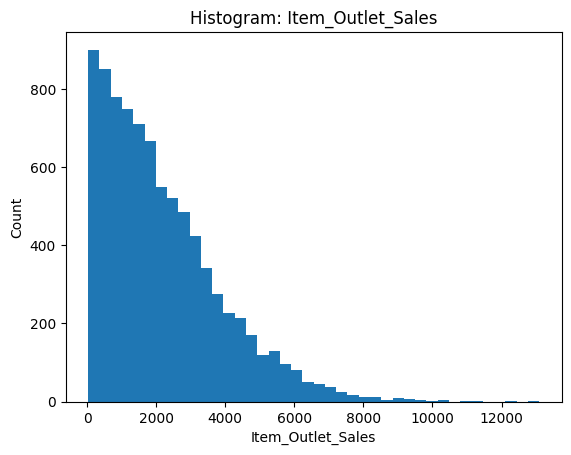

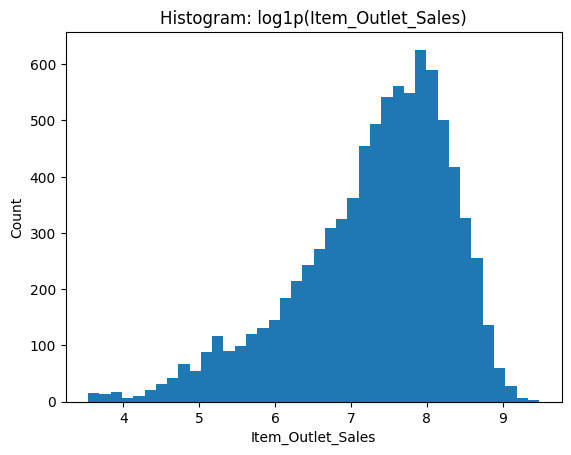

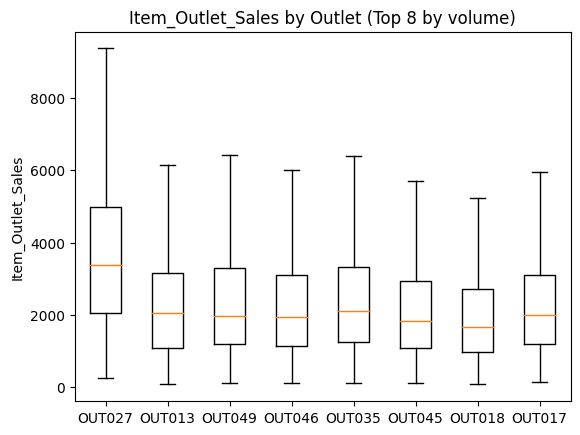


Tweedie-like variance–mean power fit across outlets:
log(var) ≈ 1.814 * log(mean) + 0.572  ->  estimated p ≈ 1.814


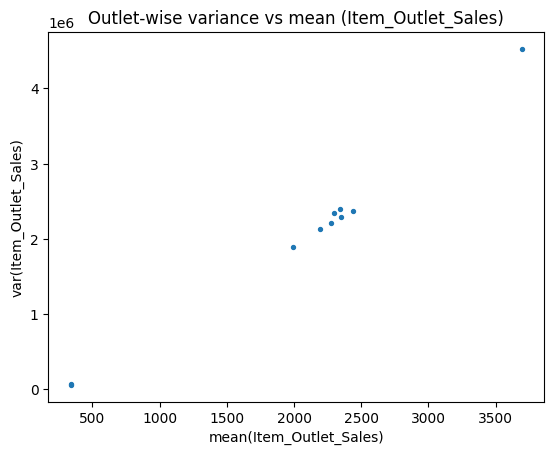

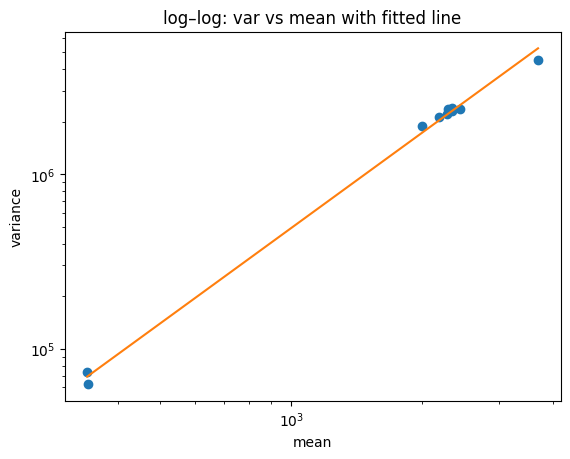

In [4]:
eda_target_distribution(train, target_col=target_col, outlet_col="Outlet_Identifier")

==== Item_Weight: Missingness + per-item stability ====
Missing fraction -> train: 0.172, test: 0.172


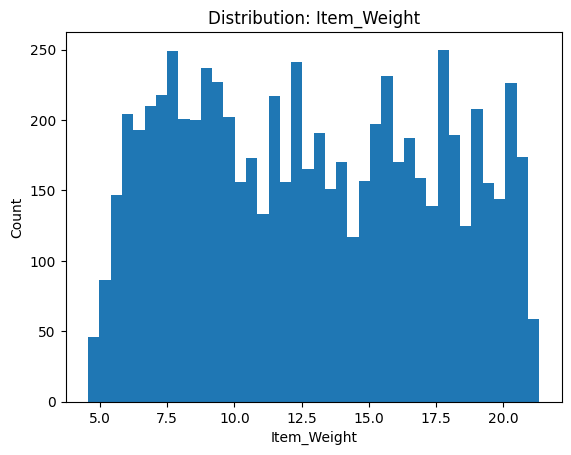

Per-item weight variability (head):


,count,mean,std,cv
Item_Identifier,,,,
FDG09,8,20.600,0.0,0.0
NCY18,8,7.285,0.0,0.0
DRE49,8,20.750,0.0,0.0
NCJ30,8,5.820,0.0,0.0
DRN47,8,12.100,0.0,0.0
FDW13,8,8.500,0.0,0.0
FDL58,8,5.780,0.0,0.0
FDP28,8,13.650,0.0,0.0
FDG57,8,14.700,0.0,0.0


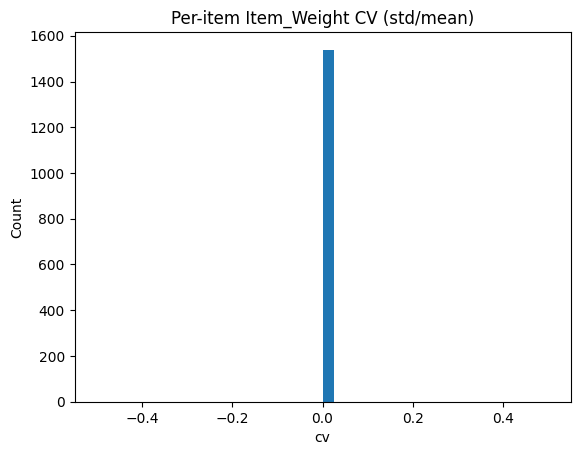

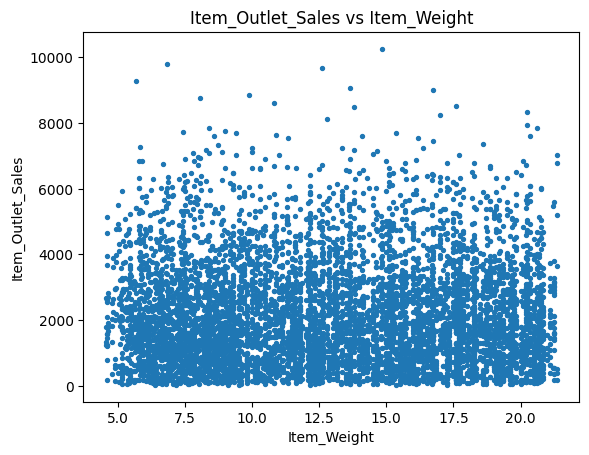

In [5]:
eda_item_weight(train, test)

==== Item_Visibility: Zero-repair + type-wise baselines ====
Fraction of exact zeros in Item_Visibility: 0.062  (strong signal to repair zeros)


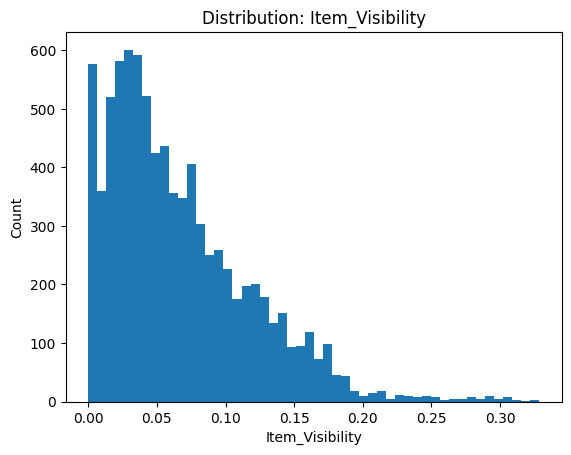

Type-wise mean visibility (excluding zeros):


,mean_visibility
Item_Type,
Breakfast,0.088126
Seafood,0.079974
Dairy,0.076701
Starchy Foods,0.075184
Baking Goods,0.074331
Fruits and Vegetables,0.073719
Canned,0.071779
Breads,0.071069
Snack Foods,0.070866


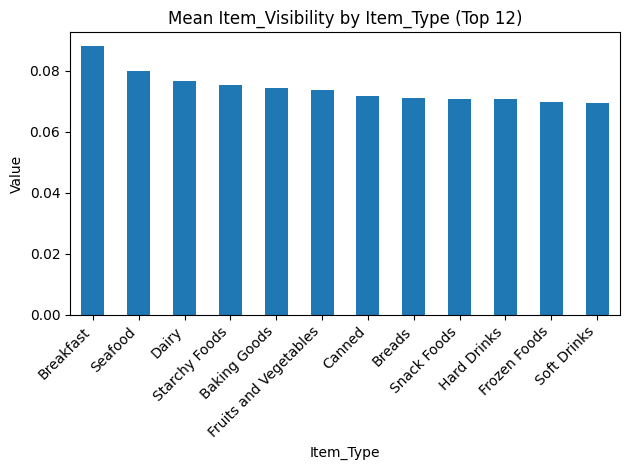

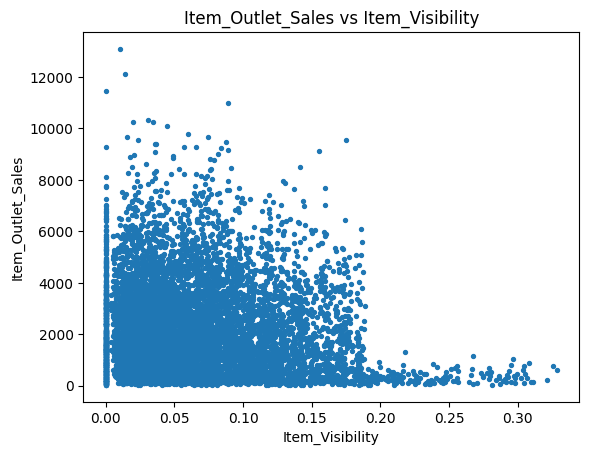

In [6]:
eda_visibility(train)

==== Outlet_Size: Impute by Outlet_Type mode ====
Missing fraction in Outlet_Size: 0.283
Outlet_Type x Outlet_Size counts (train):


Outlet_Size,High,Medium,Small
Outlet_Type,,,
Grocery Store,0,0,528
Supermarket Type1,932,930,1860
Supermarket Type2,0,928,0
Supermarket Type3,0,935,0


Dominant size per Outlet_Type (mode):


,dominant_size
Outlet_Type,
Grocery Store,Small
Supermarket Type1,Small
Supermarket Type2,Medium
Supermarket Type3,Medium


Mean target by Outlet_Size:


,mean_target
Outlet_Size,
Medium,2681.603542
High,2298.995256
Small,1912.149161


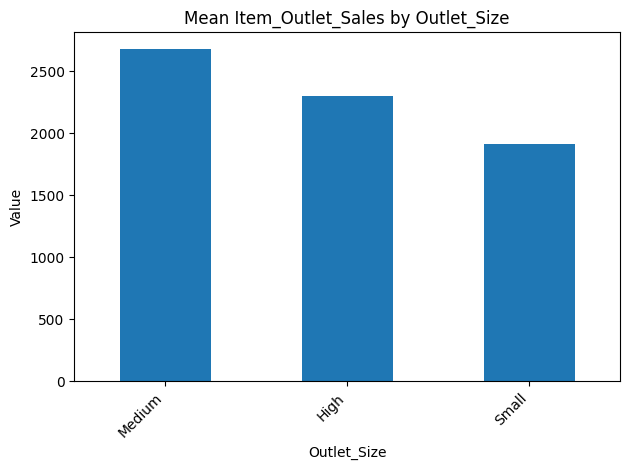

In [7]:
eda_outlet_size(train)

==== Outlet_Years: Age signal (2013 anchor) ====


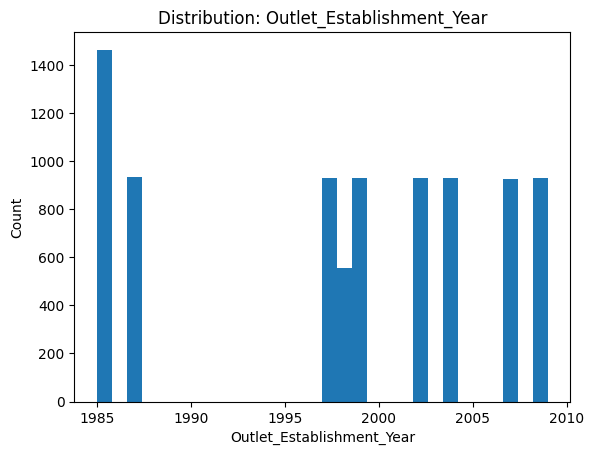

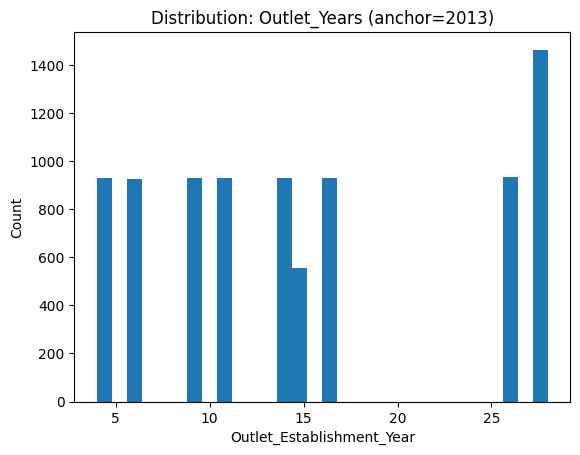

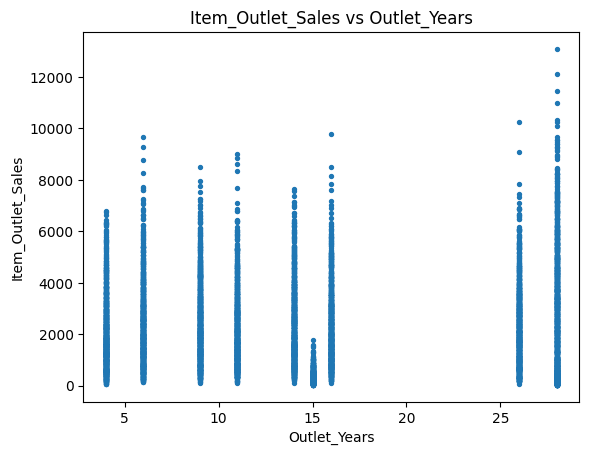

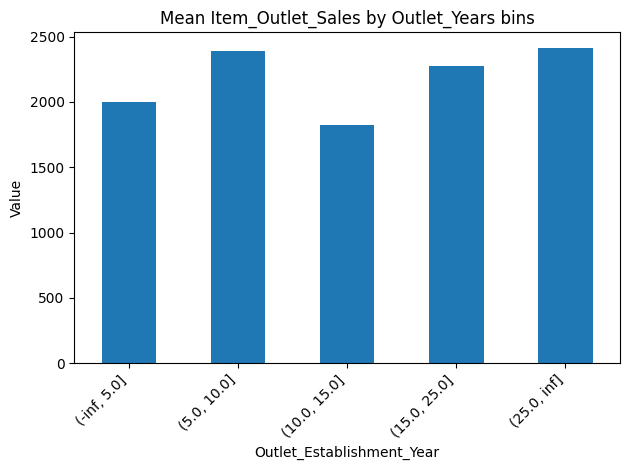

In [8]:
eda_outlet_years(train)

==== Item_Type_Combined: FD/NC/DR from Item_Identifier prefix ====
Distribution of combined types:


,count
Food,6125
Non-Consumable,1599
Drinks,799


Cross-tab: Item_Type_Combined vs Item_Type (top rows):


Item_Type,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household
Item_Identifier,,,,,,,,,,
Drinks,0,0,0,0,140,0,0,214,0,0
Food,648,251,110,649,542,856,1232,0,0,0
Non-Consumable,0,0,0,0,0,0,0,0,520,910


Fat content distribution for Non-Consumable vs others:


Item_Fat_Content,LF,Low Fat,Regular,low fat,reg
Item_Identifier,,,,,
Non-Consumable,94,1477,0,28,0
Other,222,3612,2889,84,117


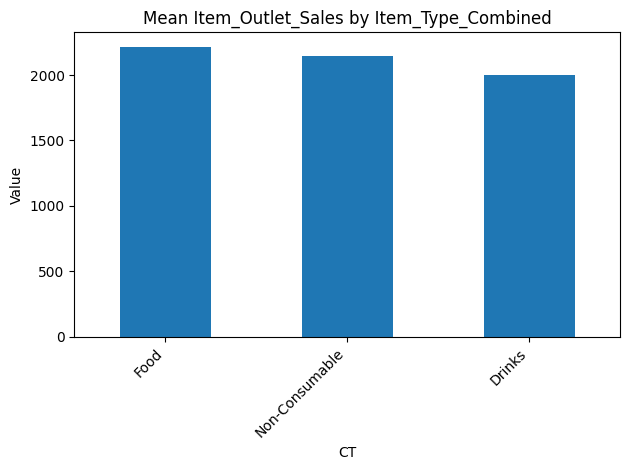

In [9]:
eda_item_type_combined(train)

==== Item_MRP_Bins: Quartiles & stepwise signal ====


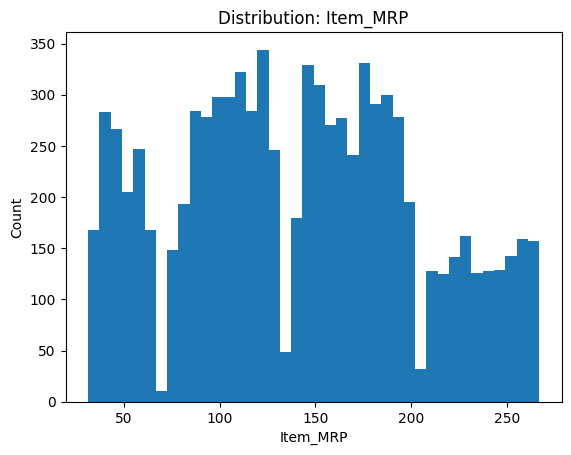

Quartiles: 25%=93.83, 50%=143.01, 75%=185.64
Mean target by MRP quartile bin:


,mean_target
Item_MRP,
"(31.288999999999998, 93.826]",948.780309
"(93.826, 143.013]",1757.214603
"(143.013, 185.644]",2576.221513
"(185.644, 266.888]",3443.124556


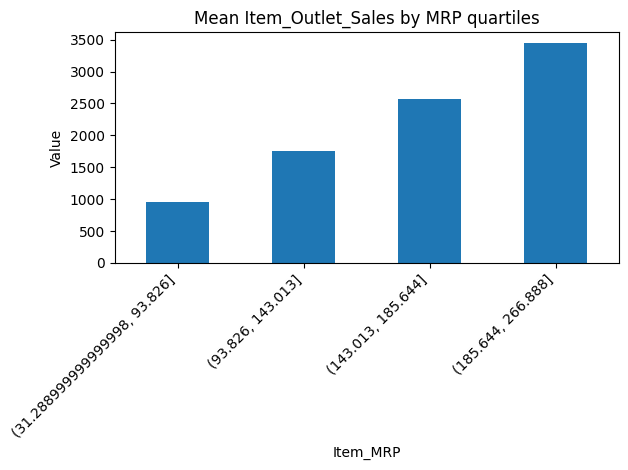

In [10]:
eda_mrp_bins(train)

==== Item_Visibility_Bins: Quantile bins & signal ====


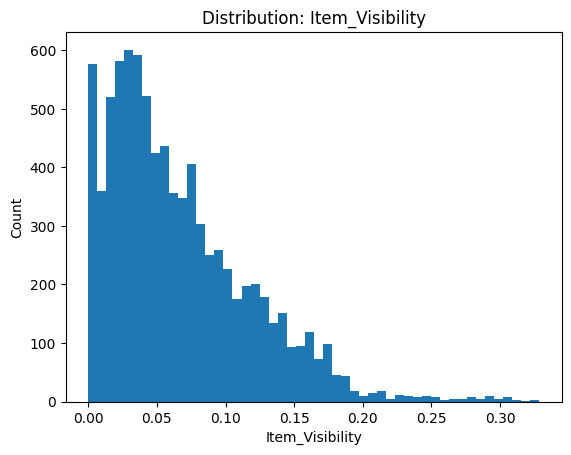

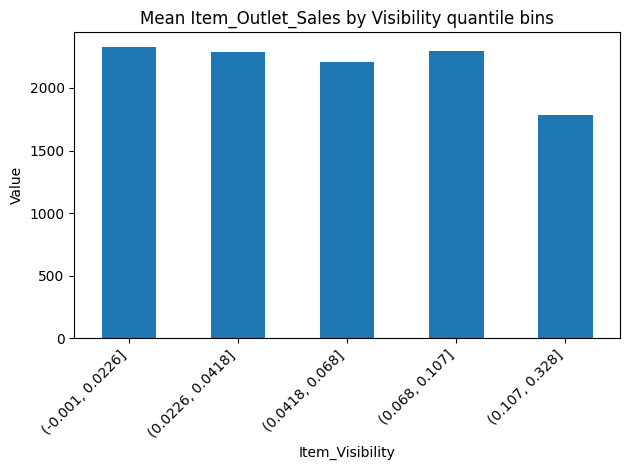

In [11]:
eda_visibility_bins(train)

==== Price_Per_Weight: Ratio scale & usefulness ====


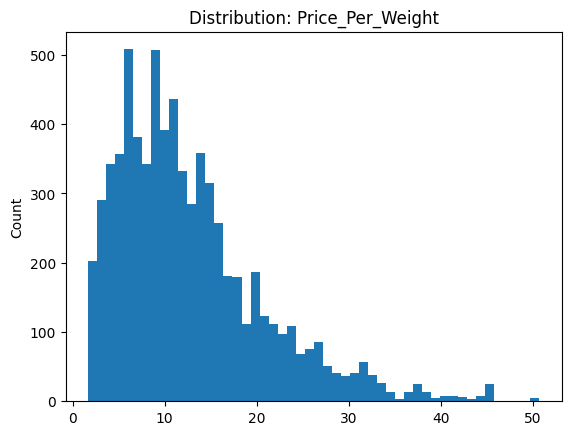

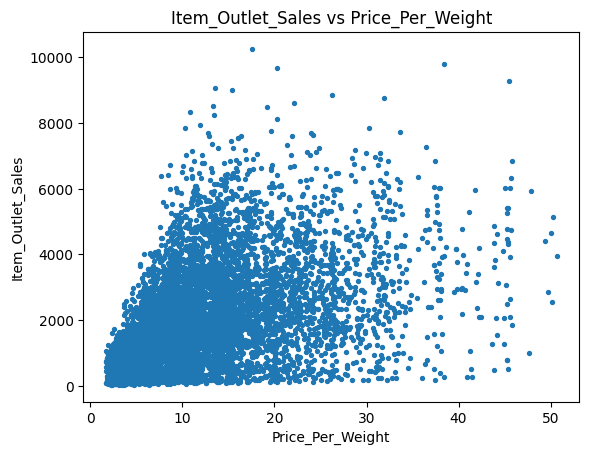

In [12]:
eda_price_per_weight(train)

==== Visibility_MRP_Ratio: Ratio sanity & outliers ====


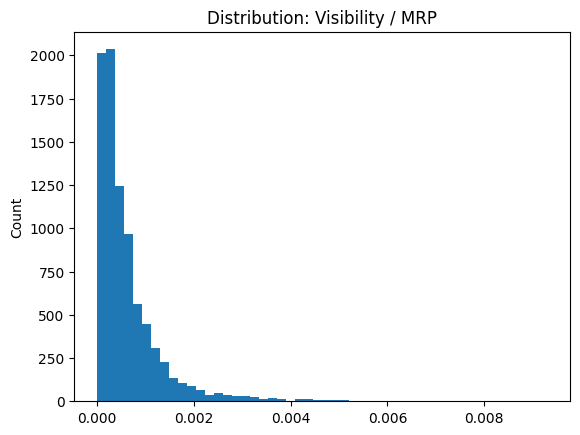

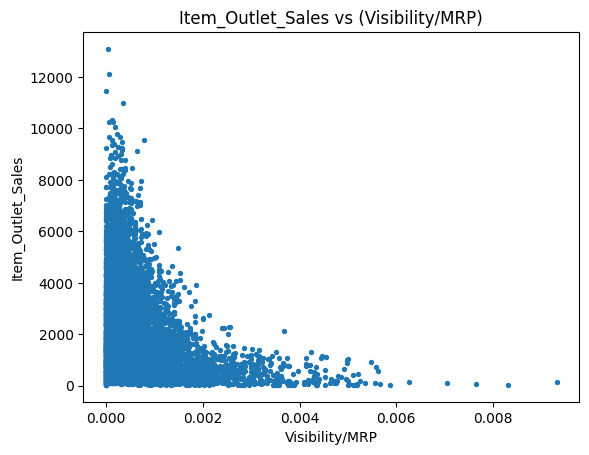

In [13]:
eda_visibility_mrp_ratio(train)

==== Store-level aggregates: why they help ====
Total rows per outlet (Store_Item_Count) — top 10:


,rows
Outlet_Identifier,
OUT027,935
OUT013,932
OUT035,930
OUT046,930
OUT049,930
OUT045,929
OUT018,928
OUT017,926
OUT010,555


Unique Item_Identifier per outlet (variety) — top 10:


,unique_items
Outlet_Identifier,
OUT027,935
OUT013,932
OUT035,930
OUT046,930
OUT049,930
OUT045,929
OUT018,928
OUT017,926
OUT010,555


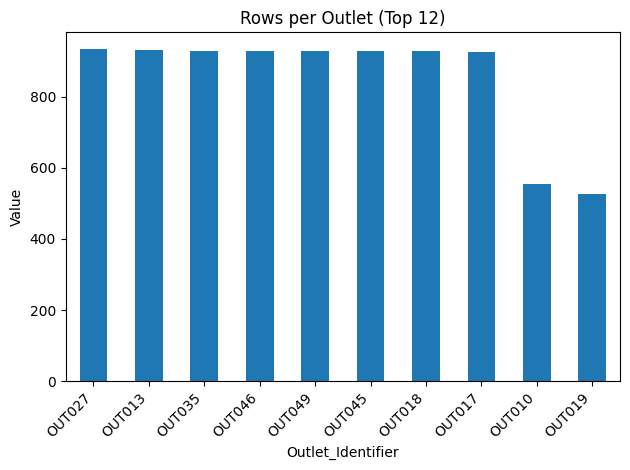

Mean Item_Outlet_Sales per outlet — top 10:


,mean_target
Outlet_Identifier,
OUT027,3694.038558
OUT035,2438.841866
OUT049,2348.354635
OUT017,2340.675263
OUT013,2298.995256
OUT046,2277.844267
OUT045,2192.384798
OUT018,1995.498739
OUT019,340.329723


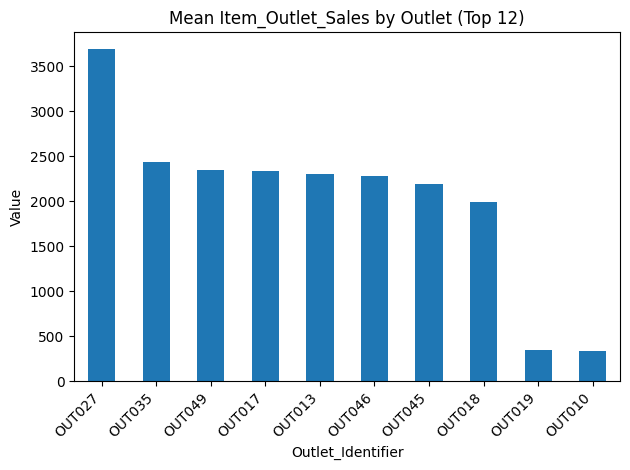

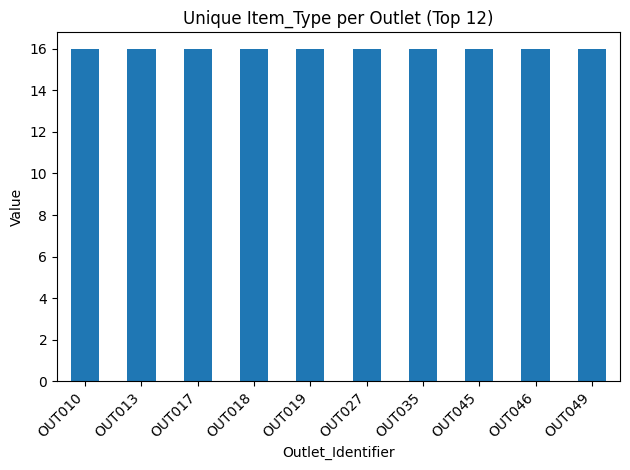

In [14]:
eda_store_level(train)

==== Item frequency (Item_Count) : popularity signal ====


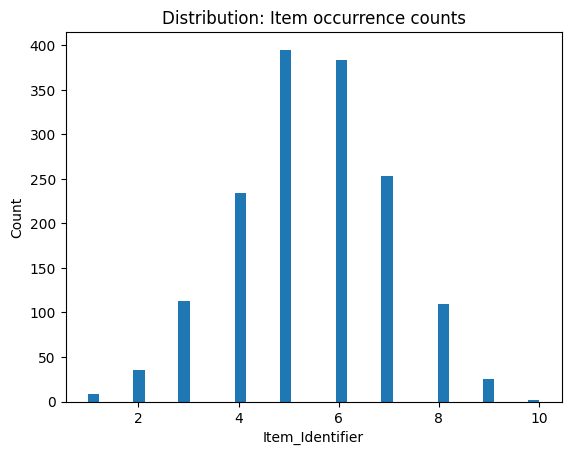

Top 10 items by mean sales:


,mean_target
Item_Identifier,
FDR45,6035.310550
NCL42,5962.017067
FDU55,5922.457450
FDZ50,5512.824000
DRK23,5464.886400
FDF39,5457.063250
FDD44,5453.900700
FDT16,5414.818240
FDY55,5332.725100


In [15]:
eda_item_frequency(train)

==== Outlet ordinals: check monotonic trends ====

Mean target by Outlet_Type:


,mean_target
Outlet_Type,
Supermarket Type3,3694.038558
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Grocery Store,339.828500


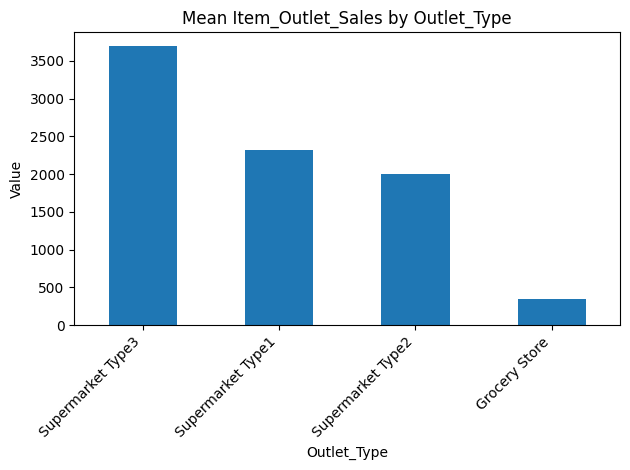


Mean target by Outlet_Location_Type:


,mean_target
Outlet_Location_Type,
Tier 2,2323.990559
Tier 3,2279.627651
Tier 1,1876.909159


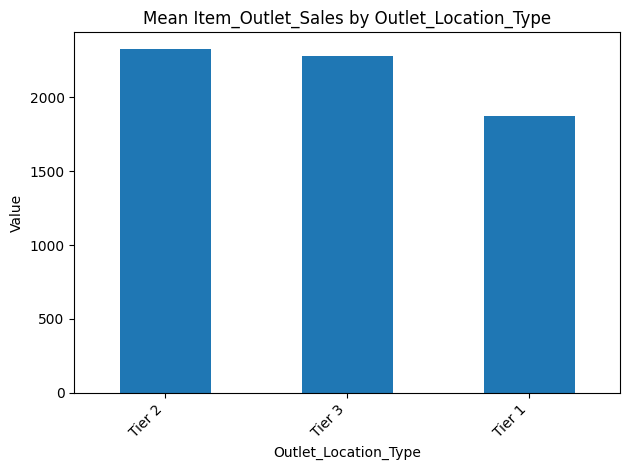


Mean target by Outlet_Size:


,mean_target
Outlet_Size,
Medium,2681.603542
High,2298.995256
Small,1912.149161


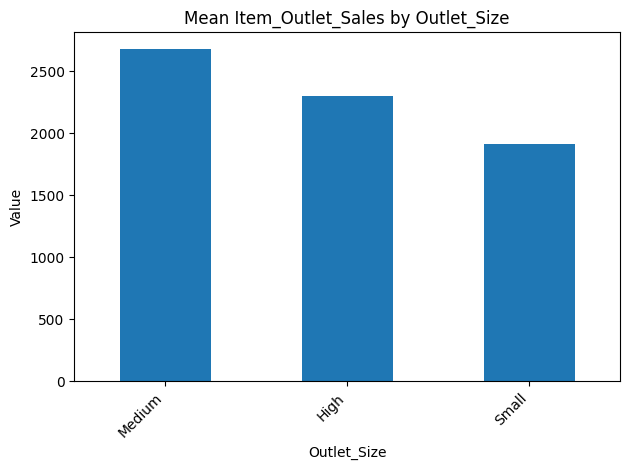

In [16]:
eda_outlet_ordinals(train)